# Assignment 5: Logistic Regression with Variable Selection

## Follow These Steps Before Submitting
Once you are finished, ensure to complete the following steps.

1.  Restart your kernel by clicking **'Runtime' > 'Restart session and run all'**.

2.  Fix any errors which result from this.

3.  Repeat steps 1. and 2. until your notebook runs without errors.

4.  Submit your completed notebook to OWL by the deadline.

# Dataset

In this assignment, you will work on a dataset taken from USGS(U.S Geological Survey). This dataset contains earthquake data with a magnitude of 4.5+ and an "alert" warning level, recorded between 1976 and 2025. Below is an explanation of the columns included in the dataset:

- **`id`**: A unique identifier for the earthquake event.
- **`time`**: The timestamp indicating when the earthquake or event occurred, including the date and time in UTC format.
- **`latitude`**: The geographical latitude of the earthquake's epicenter, measured in degrees.
- **`longitude`**: The geographical longitude of the earthquake's epicenter, measured in degrees.
- **`depth`**: The depth at which the earthquake occurred, typically measured in kilometers below the Earth's surface.
- **`mag`**: The magnitude of the earthquake, representing the energy released by the seismic event. In this case, a value of 8.6 indicates a very large earthquake.
- **`gap`**: The azimuthal gap, which refers to the angular distance between the two most distant seismic stations that recorded the earthquake. A smaller gap typically indicates better global coverage.
- **`dmin`**: The minimum distance between the earthquake's epicenter and the nearest seismic station, measured in degrees.
- **`rms`**: The root mean square of the amplitude of the seismic waves, representing the strength of the seismic signal.
- **`horizontalError`**: The error associated with the latitude and longitude coordinates of the epicenter, typically measured in kilometers.
- **`depthError`**: The error associated with the depth measurement of the earthquake, typically measured in kilometers.
- **`magError`**: The error associated with the magnitude measurement of the earthquake, representing the uncertainty in the reported magnitude.
- **`magNst`**: The number of stations that contributed to the magnitude estimation.
- **`Alert` (target)** The alert level issued for the earthquake, whether 'Severe' or 'Non-Severe'.

The goal is to train a model for predicting the **`Alert`** which indicates the severity of the earthquake.



In [1]:
# Standard imports
import numpy as np
from itertools import chain, combinations

# Data manipulation
import pandas as pd
import polars as pl

# Sklearn imports
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector

# Plotting packages
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Download the data
!gdown https://drive.google.com/uc?id=1yL84FMQrfHC_cQsa_V3KTcRAJS0k4DhY

Downloading...
From: https://drive.google.com/uc?id=1yL84FMQrfHC_cQsa_V3KTcRAJS0k4DhY
To: /content/earthquakes.parquet
100% 437k/437k [00:00<00:00, 7.28MB/s]


# Part 1: Data Preprocessing

## Question 1.1: Load data

(1) Read the **`earthquakes.parquet`** file as a **`polars.DataFrame`** and show its descriptive statistics.

(2) Drop column **`id`** and **`time`** and display the first 5 rows of the dataframe.

Since **`id`** is unique for each earthquake event that does not contain any predictive information and **`time`** is not directly informative for predicting earthquake severity unless you extract relevant features such as time of day, seasonality, etc.

In [12]:
# (1) YOUR CODE HERE
data = pl.read_parquet('earthquakes.parquet')
data.describe()

statistic,id,time,latitude,longitude,depth,mag,gap,dmin,rms,horizontalError,depthError,magError,magNst,Alert
str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str
"""count""","""7699""","""7699""",7699.0,7699.0,7699.0,7699.0,7375.0,6997.0,7673.0,6481.0,7490.0,5485.0,5632.0,"""7699"""
"""null_count""","""0""","""0""",0.0,0.0,0.0,0.0,324.0,702.0,26.0,1218.0,209.0,2214.0,2067.0,"""0"""
"""mean""",null,null,0.999312,15.173904,58.990024,5.657358,49.060709,4.109992,0.822303,6.974621,2.571899,0.06792,46.712713,null
"""std""",null,null,32.359887,128.333755,119.160114,0.514095,39.120351,5.259451,0.266227,2.806992,3.119655,0.057433,69.220344,null
"""min""","""ak012fko16th""","""1976-03-25 00:41:20.500000+00:…",-69.7739,-179.9776,-1.77,4.5,7.0,0.0,0.04,0.08,0.0,0.0,0.0,"""Non-Severe"""
"""25%""",null,null,-21.7389,-109.6226,10.0,5.4,25.0,1.047,0.66,5.6,1.7,0.047,18.0,null
"""50%""",null,null,-3.5114,42.1877,13.7,5.6,38.0,2.407,0.82,7.1,1.8,0.059,29.0,null
"""75%""",null,null,28.2943,141.2441,42.0,5.9,59.0,4.969,0.99,8.6,2.9,0.073,47.0,null
"""max""","""uw61562126""","""2024-12-23 06:00:59.074000+00:…",85.729,179.9981,670.81,8.6,321.0,39.934,2.1,88.54,31.95,1.642,954.0,"""Severe"""


In [13]:
# (2) YOUR CODE HERE
data = data.drop(['id', 'time'])
data.head()

latitude,longitude,depth,mag,gap,dmin,rms,horizontalError,depthError,magError,magNst,Alert
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str
35.59,-90.48,15.0,4.62,null,null,null,null,null,null,0.0,"""Non-Severe"""
32.998667,-115.5575,14.19,5.8,79.0,0.05768,0.17,1.03,1.78,null,0.0,"""Severe"""
38.19,-83.95,10.0,5.0,null,null,null,null,null,null,null,"""Non-Severe"""
35.816,-117.816333,4.766,4.7,135.0,null,0.66,2.51,31.61,0.424,9.0,"""Non-Severe"""
33.0955,-115.6245,18.904,5.75,34.0,null,0.34,0.56,0.67,0.161,6.0,"""Non-Severe"""


## Question 1.2: Handle null values

The result of the `null_count` function indicates that some columns contain null values. Fill these null values with the median of the corresponding column and display the first 5 rows of the resulting dataframe.

In [16]:
data.null_count() # uncomment and run this code

latitude,longitude,depth,mag,gap,dmin,rms,horizontalError,depthError,magError,magNst,Alert
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,0,0


In [15]:
# YOUR CODE HERE
data = data.with_columns([
    pl.col('gap').fill_null(pl.col('gap').median()),
    pl.col('dmin').fill_null(pl.col('dmin').median()),
    pl.col('rms').fill_null(pl.col('rms').median()),
    pl.col('horizontalError').fill_null(pl.col('horizontalError').median()),
    pl.col('depthError').fill_null(pl.col('depthError').median()),
    pl.col('magError').fill_null(pl.col('magError').median()),
    pl.col('magNst').fill_null(pl.col('magNst').median())
  ])

## Question 1.3: Explore target distribution

Count the number of instances of each severity level of the earthquake in the dataset.

Comment on your findings, providing insights into the distribution of different severity levels.

In [21]:
# YOUR CODE HERE
counts = data['Alert'].value_counts()
counts

Alert,count
str,u32
"""Severe""",331
"""Non-Severe""",7368


The distribution appears to contain far more Non-Severe alerts than Severe alerts. Perhaps this data may not be even enough for the model to find a pattern?


## Question 1.4: Convert target variable

Convert **`Alert`** to a binary numerical target:
- Replace **`Severe`** with 1.
- Replace **`Non-Severe`** with 0.

Display the first 5 rows of the resulting dataframe.

Hint: If you use the `replace` method, the resulting column will still be of string type. Use `cast` to make it `Float64` after replacement.

In [23]:
# YOUR CODE HERE
data = data.with_columns(
    data["Alert"].replace({"Severe": 1, "Non-Severe": 0})
)
data.head()

latitude,longitude,depth,mag,gap,dmin,rms,horizontalError,depthError,magError,magNst,Alert
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str
35.59,-90.48,15.0,4.62,38.0,2.407,0.82,7.1,1.8,0.059,0.0,"""0"""
32.998667,-115.5575,14.19,5.8,79.0,0.05768,0.17,1.03,1.78,0.059,0.0,"""1"""
38.19,-83.95,10.0,5.0,38.0,2.407,0.82,7.1,1.8,0.059,29.0,"""0"""
35.816,-117.816333,4.766,4.7,135.0,2.407,0.66,2.51,31.61,0.424,9.0,"""0"""
33.0955,-115.6245,18.904,5.75,34.0,2.407,0.34,0.56,0.67,0.161,6.0,"""0"""


## Question 1.5: Train test split

Split the dataset into training and testing sets:
- With **30% testing data** and **70% training data**.
- Set the **random state** to **2025**.
- Use **stratified splitting** to **maintain the same proportion of each class** in the target variable (**`Alert`**) in both the training and testing sets.

Display the descriptive statistics for X_train and X_test.

In [26]:
# YOUR CODE HERE
X_train, X_test, y_train, y_test = train_test_split(data.drop('Alert'),
                                                    data.select('Alert'),
                                                    test_size = 0.3,
                                                    random_state = 2025,
                                                    stratify=data["Alert"] )

# Part 2: Sequential Feature Selection

## Question 2.1: Forward Selection

Create a pipeline using [`SequentialFeatureSelector`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html) to perform **forward** feature selection:
- Standardize the data, ensuring each feature has a mean of 0 and a standard deviation of 1.
- Use **ROC AUC** as the scoring metric for feature selection. Conduct **5-fold cross-validation** to evaluate the model. Set the **tolerance for stopping** the selection process to **0.001**.
- Configure the logistic regression to use the default **`lbfgs`** as solver with **no penalty**. Set the **maximum number of iterations** to **1000**. Use a **balanced** weight that adjust weights inversely proportional to class frequencies in the input data. Set the **random state** to **2025**.

Fit the pipeline and report the subset of variables on this method.


In [34]:
# YOUR CODE HERE
selector_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('sfs', SequentialFeatureSelector(LogisticRegression(solver = 'lbfgs',
                                                    penalty = None,
                                                    max_iter = 1000,
                                                    verbose = 0,
                                                    random_state = 2025,
                                                    n_jobs = 1,
                                                    class_weight = 'balanced'),
                          direction = 'forward',
                          scoring = 'roc_auc',
                          cv=5,
                          tol=0.001,
                          n_jobs = -1))

    ])

# Fit the pipeline
selector_pipe.fit(X_train, y_train.to_numpy().ravel())
# Get the selected features
selected_forward = selector_pipe.named_steps['sfs'].get_feature_names_out(input_features = X_train.columns)
selected_forward

array(['latitude', 'depth', 'mag', 'dmin', 'horizontalError'],
      dtype=object)

## Question 2.2: Backward Selection

Create a pipeline using [`SequentialFeatureSelector`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html) to perform **backward** feature selection. Keep all other configurations the same as in the previous question

Fit the pipeline and report the subset of variables on this method.


In [35]:
# YOUR CODE HERE
# YOUR CODE HERE
selector_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('sfs', SequentialFeatureSelector(LogisticRegression(solver = 'lbfgs',
                                                    penalty = None,
                                                    max_iter = 1000,
                                                    verbose = 0,
                                                    random_state = 2025,
                                                    n_jobs = 1,
                                                    class_weight = 'balanced'),
                          direction = 'backward',
                          scoring = 'roc_auc',
                          cv=5,
                          tol=0.001,
                          n_jobs = -1))

    ])

# Fit the pipeline


selector_pipe.fit(X_train, y_train.to_numpy().ravel())
selected_backward = selector_pipe.named_steps['sfs'].get_feature_names_out(input_features = X_train.columns)
selected_backward

array(['latitude', 'longitude', 'depth', 'mag', 'gap', 'dmin',
       'horizontalError', 'depthError', 'magError', 'magNst'],
      dtype=object)

## Question 2.3: Compare results & find the best model

Compare and discuss the selected subset of variables obtained from both methods used in the previous steps.

Perform an **exhaustive search** over all possible subsets of the remaining variables using **5-fold cross-validation** to find the best model. Use the same Logistic Regression configurations as in previous questions.

Hint: If you have correctly followed the previous steps, you should have **five remaining variables** to evaluate in the exhaustive search.

(Your written answer here)

Among all 11 variables, forward selection resulted in 5 features, while backward selection selected 10 features. This indicates that backward selection retains more variables, perhaps due to its nature of removing less impactful features instead of building up the model iteratively. Both selection results agree on keeping `['latitude', 'depth', 'mag', 'dmin', 'horizontalError']`. We should then conduct an exhaustive search using the remaining five variables `['longitude', 'gap', 'depthError', 'magError', 'magNst']`.

In [36]:
# YOUR CODE HERE
exhaust_vars = ['longitude', 'gap', 'depthError', 'magError', 'magNst']

n_features = len(exhaust_vars)
subsets = chain.from_iterable(combinations(range(n_features), k + 1)
            for k in range(n_features))

best_score = -np.inf
best_subset = None

# Create a pipeline with scaler and logistic regression
sequential_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(solver = 'lbfgs',
                                  penalty = None,
                                  max_iter = 1000,
                                  verbose = 0,
                                  random_state = 42,
                                  n_jobs = -1,
                                  class_weight = 'balanced'))
])

# Iterate over all subsets
for subset in subsets:
    # Combine the selected forward features with the subset, from the exhaustive search
    subset_vars = list(selected_forward) + [exhaust_vars[i] for i in subset]
    score = cross_val_score(sequential_pipe,
                            X_train.select(subset_vars),
                             y_train.to_numpy().ravel(),
                             cv=5).mean()
    if score > best_score:
        best_score, best_subset = score, subset

# Get the best subset
best_subset_vars = list(selected_forward) + [exhaust_vars[i] for i in best_subset]
best_subset_vars

['latitude',
 'depth',
 'mag',
 'dmin',
 'horizontalError',
 'gap',
 'depthError',
 'magNst']

## Question 2.4: Fit the best model

Train a logistic regression model with the best variables selected.

Display the model's coefficients and intercept.

In [37]:
# YOUR CODE HERE
sequential_pipe.fit(X_train.select(best_subset_vars), y_train.to_numpy().ravel())

# Get the coefficients and intercept
coefficients = sequential_pipe.named_steps['logreg'].coef_
intercept = sequential_pipe.named_steps['logreg'].intercept_

print("Coefficients:", coefficients)
print("Intercept:", intercept)

Coefficients: [[ 1.10200608 -2.80335111  1.30224936 -0.86671344 -0.49843883 -0.45540619
   0.27323239 -0.17771873]]
Intercept: [-2.1618635]


## Question 2.5: Measure model's performance

Construct a **95% confidence interval** for both accuracy and AUC using **100 bootstrap resamples** of the test set.

In [38]:
np.random.seed(2025) # DO NOT DELETE
# YOUR CODE HERE

# Apply the model to the test set
y_pred = sequential_pipe.predict(X_test.select(best_subset_vars))
y_prob = sequential_pipe.predict_proba(X_test.select(best_subset_vars))[:, 1]

# Get the accuracy and AUC scores for the test set
accuracy = accuracy_score(y_test.to_pandas(), y_pred)
auc = roc_auc_score(y_test.to_pandas(), y_prob)

# Create a bootstrap measurement for accuracy and AUC. We will use 100 bootstraps. Normally we would use 1000 or more.
n_bootstraps = 100
bootstrapped_accuracy = np.zeros(n_bootstraps)
bootstrapped_auc = np.zeros(n_bootstraps)

for i in range(n_bootstraps):
    # Get the indices for the bootstrap sample
    idx = np.random.choice(len(y_test), len(y_test), replace=True)

    # Get the accuracy of the bootstrap sample
    bootstrapped_accuracy[i] = accuracy_score(y_test.to_pandas().iloc[idx], y_pred[idx])

    # Get the AUC of the bootstrap sample
    bootstrapped_auc[i] = roc_auc_score(y_test.to_pandas().iloc[idx], y_prob[idx])

# Get the differences between the bootstrapped values and the original values
accuracy_diff = bootstrapped_accuracy - accuracy
auc_diff = bootstrapped_auc - auc

# Calculate the 95% confidence interval for the accuracy and AUC
accuracy_ci = np.percentile(accuracy_diff, [2.5, 97.5])
auc_ci = np.percentile(auc_diff, [2.5, 97.5])

# Print the results. Centre the values around the original values.
print(f"The 95% confidence interval for the accuracy (sequential) is [{(accuracy - accuracy_ci[1])*100:.2f}%, {(accuracy - accuracy_ci[0])*100:.2f}%]")
print(f"The 95% confidence interval for the AUC (sequential) is [{(auc - auc_ci[1]):.2f}, {(auc - auc_ci[0]):.2f}]")

The 95% confidence interval for the accuracy (sequential) is [78.68%, 81.84%]
The 95% confidence interval for the AUC (sequential) is [0.85, 0.91]


# Part 3: Regularization

## Question 3.1: Ridge penalization

Create a pipeline using [`LogisticRegressionCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html) to implement a logistic regression with **Ridge penalization**:
- Standardize the data, ensuring each feature has a mean of 0 and a standard deviation of 1.
- Configure the **`LogisticRegressionCV`** to use **`saga`** as solver. Use the default **`Cs = 10`**. Set the **maximum number of iterations** to **1000**. Use a **balanced** weight that adjust weights inversely proportional to class frequencies in the input data. Set the **random state** to **2025**. Use **5-fold cross-validation**.

Fit the pipeline to get the best model.

Construct a **95% confidence interval** for both accuracy and AUC using **100 bootstrap resamples** of the test set.

In [39]:
np.random.seed(2025) # DO NOT DELETE

# YOUR CODE HERE
# Create a pipeline using LogisticRegressionCV to get the best model.
ridge_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegressionCV(solver = 'saga',
                                    Cs = 10,
                                    penalty = 'elasticnet',
                                    max_iter = 1000,
                                    verbose = 0,
                                    random_state = 42,
                                    n_jobs = -1,
                                    class_weight = 'balanced',
                                    l1_ratios = [0],
                                    cv = 5))
])

# Fit the pipeline
ridge_pipe.fit(X_train, y_train.to_numpy().ravel())

# Apply the model to the test set
y_pred = ridge_pipe.predict(X_test)
y_prob = ridge_pipe.predict_proba(X_test)[:, 1]

# Get the accuracy and AUC scores for the test set
accuracy = accuracy_score(y_test.to_pandas(), y_pred)
auc = roc_auc_score(y_test.to_pandas(), y_prob)

# Create a bootstrap measurement for accuracy and AUC. We will use 100 bootstraps. Normally we would use 1000 or more.
n_bootstraps = 100
bootstrapped_accuracy = np.zeros(n_bootstraps)
bootstrapped_auc = np.zeros(n_bootstraps)

for i in range(n_bootstraps):
    # Get the indices for the bootstrap sample
    idx = np.random.choice(len(y_test), len(y_test), replace=True)

    # Get the accuracy of the bootstrap sample
    bootstrapped_accuracy[i] = accuracy_score(y_test.to_pandas().iloc[idx], y_pred[idx])

    # Get the AUC of the bootstrap sample
    bootstrapped_auc[i] = roc_auc_score(y_test.to_pandas().iloc[idx], y_prob[idx])

# Get the differences between the bootstrapped values and the original values
accuracy_diff = bootstrapped_accuracy - accuracy
auc_diff = bootstrapped_auc - auc

# Calculate the 95% confidence interval for the accuracy and AUC
accuracy_ci = np.percentile(accuracy_diff, [2.5, 97.5])
auc_ci = np.percentile(auc_diff, [2.5, 97.5])

# Print the results. Centre the values around the original values.
print(f"The 95% confidence interval for the accuracy (Ridge) is [{(accuracy - accuracy_ci[1])*100:.2f}%, {(accuracy - accuracy_ci[0])*100:.2f}%]")
print(f"The 95% confidence interval for the AUC (Ridge) is [{(auc - auc_ci[1]):.2f}, {(auc - auc_ci[0]):.2f}]")

The 95% confidence interval for the accuracy (Ridge) is [78.57%, 81.50%]
The 95% confidence interval for the AUC (Ridge) is [0.86, 0.91]


## Question 3.2: Lasso penalization

Create a pipeline using [`LogisticRegressionCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html) to implement a logistic regression with **Lasso penalization**:
- Standardize the data, ensuring each feature has a mean of 0 and a standard deviation of 1.
- Configure the **`LogisticRegressionCV`** to use **`saga`** as solver. Use the default **`Cs = 10`**. Set the **maximum number of iterations** to **1000**. Use a **balanced** weight that adjust weights inversely proportional to class frequencies in the input data. Set the **random state** to **2025**. Use **5-fold cross-validation**.

Fit the pipeline to get the best model.

Construct a **95% confidence interval** for both accuracy and AUC using **100 bootstrap resamples** of the test set.

In [40]:
np.random.seed(2025) # DO NOT DELETE

# YOUR CODE HERE
# Create a pipeline using LogisticRegressionCV to get the best model.
lasso_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegressionCV(solver = 'saga',
                                    Cs = 10,
                                    penalty = 'l1',
                                    max_iter = 1000,
                                    verbose = 0,
                                    random_state = 42,
                                    n_jobs = -1,
                                    class_weight = 'balanced',
                                    #l1_ratios = [1],
                                    cv = 5))
])

# Fit the pipeline
lasso_pipe.fit(X_train, y_train.to_numpy().ravel())

# Apply the model to the test set
y_pred = lasso_pipe.predict(X_test)
y_prob = lasso_pipe.predict_proba(X_test)[:, 1]

# Get the accuracy and AUC scores for the test set
accuracy = accuracy_score(y_test.to_pandas(), y_pred)
auc = roc_auc_score(y_test.to_pandas(), y_prob)

# Create a bootstrap measurement for accuracy and AUC. We will use 100 bootstraps. Normally we would use 1000 or more.
n_bootstraps = 100
bootstrapped_accuracy = np.zeros(n_bootstraps)
bootstrapped_auc = np.zeros(n_bootstraps)

for i in range(n_bootstraps):
    # Get the indices for the bootstrap sample
    idx = np.random.choice(len(y_test), len(y_test), replace=True)

    # Get the accuracy of the bootstrap sample
    bootstrapped_accuracy[i] = accuracy_score(y_test.to_pandas().iloc[idx], y_pred[idx])

    # Get the AUC of the bootstrap sample
    bootstrapped_auc[i] = roc_auc_score(y_test.to_pandas().iloc[idx], y_prob[idx])

# Get the differences between the bootstrapped values and the original values
accuracy_diff = bootstrapped_accuracy - accuracy
auc_diff = bootstrapped_auc - auc

# Calculate the 95% confidence interval for the accuracy and AUC
accuracy_ci = np.percentile(accuracy_diff, [2.5, 97.5])
auc_ci = np.percentile(auc_diff, [2.5, 97.5])

# Print the results. Centre the values around the original values.
print(f"The 95% confidence interval for the accuracy (LASSO) is [{(accuracy - accuracy_ci[1])*100:.2f}%, {(accuracy - accuracy_ci[0])*100:.2f}%]")
print(f"The 95% confidence interval for the AUC (LASSO) is [{(auc - auc_ci[1]):.2f}, {(auc - auc_ci[0]):.2f}]")

The 95% confidence interval for the accuracy (LASSO) is [78.98%, 81.93%]
The 95% confidence interval for the AUC (LASSO) is [0.86, 0.91]


## Question 3.3: Ridge vs Lasso

Report the coefficients from the best-performing models with Ridge and Lasso penalties.

Compare and discuss how the coefficient magnitudes differ between Ridge and Lasso, and explain.

In [46]:

# Extract feature names
feature_names = X_train.columns

# Get coefficients from the trained models
ridge_coefs = ridge_pipe.named_steps['logreg'].coef_.flatten()
lasso_coefs = lasso_pipe.named_steps['logreg'].coef_.flatten()

# Create a DataFrame to compare coefficients
coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Ridge Coefficients": ridge_coefs,
    "Lasso Coefficients": lasso_coefs
})

# Sort by absolute magnitude of Lasso coefficients
coef_df["Abs Lasso Coefs"] = coef_df["Lasso Coefficients"].abs()
coef_df = coef_df.sort_values(by="Abs Lasso Coefs", ascending=False).drop(columns="Abs Lasso Coefs")

# Display the table
print(coef_df)




            Feature  Ridge Coefficients  Lasso Coefficients
2             depth           -2.691401           -2.044934
3               mag            1.251419            1.154171
0          latitude            1.068825            0.997260
5              dmin           -0.944617           -0.685507
7   horizontalError           -0.459505           -0.452796
4               gap           -0.475611           -0.350812
8        depthError            0.290107            0.207861
9          magError           -0.376476           -0.195062
10           magNst           -0.218951           -0.143757
6               rms           -0.129245           -0.084916
1         longitude            0.114890            0.080537


Ridge Regression (L2 Regularization)

Ridge shrinks coefficients but does not force them to zero.
All features remain in the model, but their importance is reduced.
Coefficients are more evenly distributed across all features.
Lasso Regression (L1 Regularization)

Lasso performs feature selection by setting some coefficients to exactly zero.
Many features have coefficients reduced to zero, meaning they are removed from the model.
It leads to a sparser model, useful for interpretability.


# Part 4: Overall Comparison

Compare the best models obtained using **Sequential Feature Selection**, **Ridge Regularization**, and **Lasso Regularization** by plotting the ROC curve for each model on a single plot. Additionally, include a diagonal reference line representing random classification performance (i.e., an ROC curve with an AUC of 0.5).

Provide a brief analysis and comment on your findings (no need to identify the best model).

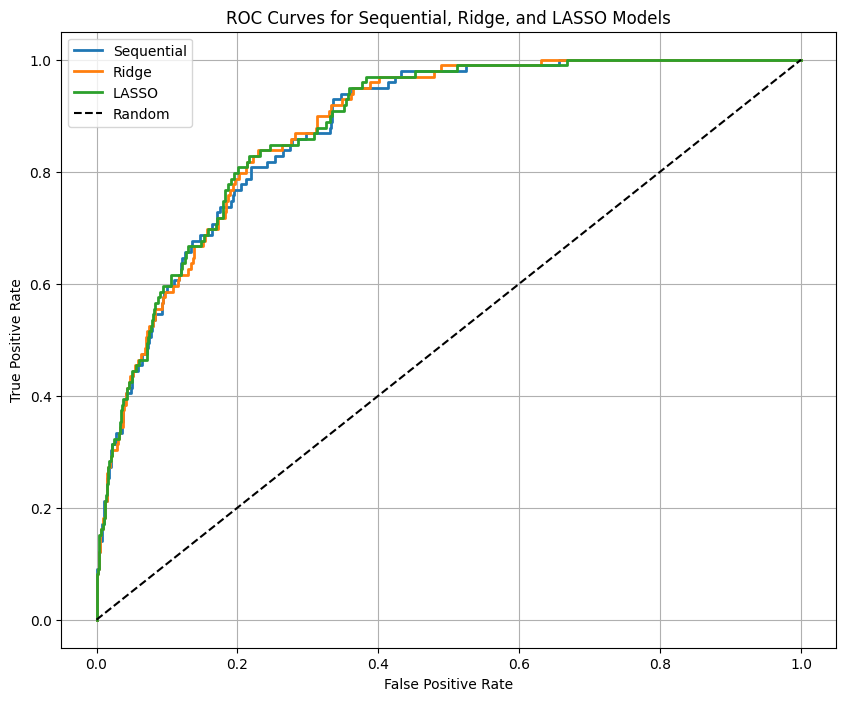

In [45]:
# Convert y_test to integer type
y_test_int = y_test.to_pandas().astype(int)

# Calculate the ROC curves for all models
fpr_seq, tpr_seq, _ = roc_curve(y_test_int, sequential_pipe.predict_proba(X_test[best_subset_vars])[:, 1])
fpr_ridge, tpr_ridge, _ = roc_curve(y_test_int, ridge_pipe.predict_proba(X_test)[:, 1])
fpr_lasso, tpr_lasso, _ = roc_curve(y_test_int, lasso_pipe.predict_proba(X_test)[:, 1])

# Plot the ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr_seq, tpr_seq, label='Sequential', linewidth=2)
plt.plot(fpr_ridge, tpr_ridge, label='Ridge', linewidth=2)
plt.plot(fpr_lasso, tpr_lasso, label='LASSO', linewidth=2)

# Add diagonal reference line for random classification
plt.plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1.5)

# Labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Sequential, Ridge, and LASSO Models')
plt.legend()
plt.grid(True)
plt.show()


(Your written answer here)

The comparison of ROC curves shows that all three models—Sequential Feature Selection (SFS), Ridge Regression, and Lasso Regression—outperform a random classifier, indicating their strong ability to differentiate between Severe and Non-Severe earthquakes. The curves for SFS and Lasso are very similar, suggesting that both methods effectively identify the most important features while allowing for model flexibility. Ridge Regression, though still performing well, slightly lags behind the others in some areas, implying that keeping all features with minor weight adjustments may not always be the best approach. Overall, all models exhibit a high True Positive Rate (TPR) and a relatively low False Positive Rate (FPR), indicating that the dataset contains robust signals for predicting earthquake severity. However, the trade-off between feature selection (Lasso, SFS) and full regularization (Ridge) suggests that while the performance across models is similar, they differ in terms of interpretability and model complexity.


The comparison of ROC curves shows that all three models—Sequential Feature Selection (SFS), Ridge Regression, and Lasso Regression—outperform a random classifier, indicating their strong ability to differentiate between Severe and Non-Severe earthquakes. The curves for SFS and Lasso are very similar, suggesting that both methods effectively identify the most important features while allowing for model flexibility. Ridge Regression, though still performing well, slightly lags behind the others in some areas, implying that keeping all features with minor weight adjustments may not always be the best approach. Overall, all models exhibit a high True Positive Rate (TPR) and a relatively low False Positive Rate (FPR), indicating that the dataset contains robust signals for predicting earthquake severity. However, the trade-off between feature selection (Lasso, SFS) and full regularization (Ridge) suggests that while the performance across models is similar, they differ in terms of interpretability and model complexity.